In [121]:
# === [Imports] ===
import numpy as np
import pandas as pd
import yfinance as yf
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from datetime import datetime,timedelta
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [122]:
ticker = 'KO'

# === [Hyperparameters] ===
n_days = 1 #Predict 1 day forward
sequence_length = 60 # Will use past 60 days'prices to predict the next day
test_size = 0.2 #20% of the data will be used for testing
embed_dim = 32
num_heads = 2
ff_dim = 32
num_blocks = 2
dropout = 0.1
lr = 0.001
batch_size = 32
epochs = 100

In [123]:
start_date = '2015-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')

df = yf.download(ticker, start=start_date, end=end_date)
df.columns = df.columns.droplevel(1)
df.dropna(inplace=True)
df

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Date,,,,,
2015-01-02,30.437510,30.625308,30.191929,30.524184,9921100
2015-01-05,30.437510,31.037016,30.394174,30.834771,26292600
2015-01-06,30.668629,31.015330,30.509726,30.632515,16897500
2015-01-07,31.051453,31.138127,30.755312,30.914215,13412300
2015-01-08,31.427050,31.470388,31.130909,31.188694,21743600
...,...,...,...,...,...
2025-05-15,71.610001,71.730003,69.599998,69.699997,19817100
2025-05-16,72.000000,72.260002,71.430000,71.860001,18441200
2025-05-19,71.930000,72.169998,71.639999,72.029999,13282800


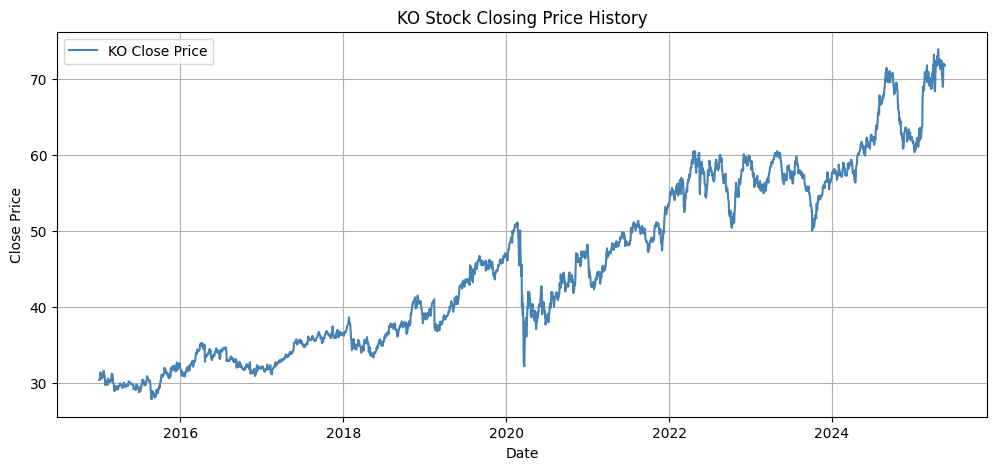

In [124]:
# Visualize the raw data (closing price)
plt.figure(figsize=(12, 5))
plt.plot(df['Close'], label=f'{ticker} Close Price', color='steelblue')
plt.title(f'{ticker} Stock Closing Price History')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid(True)
plt.legend()
plt.show()


In [125]:
def create_features(df, lags=[1, 3, 5, 10, 20], sma_windows=[5, 10, 20, 60], vol_window=20):
    """
    Create feature factors based on OHLCV data.

    Args:
        df (pd.DataFrame): DataFrame containing OHLCV data, indexed by datetime
        lags (list): List of lags for calculating log returns
        sma_windows (list): List of window sizes for calculating simple moving averages (SMA)
        vol_window (int): Window size for calculating volatility

    Returns:
        pd.DataFrame: DataFrame containing generated features (rows with NaNs removed)
    """
    print("Starting feature engineering...")
    df_feat = df.copy()

    # Calculate log return (clip to avoid division errors with 0 or negative prices)
    df_feat['log_return'] = np.log(df_feat['Close'].clip(lower=1e-9) / df_feat['Close'].shift(1).clip(lower=1e-9))

    # Lagged log return features
    for lag in lags:
        df_feat[f'log_return_lag{lag}'] = df_feat['log_return'].shift(lag)

    # Simple Moving Average (SMA) features
    for window in sma_windows:
        df_feat[f'sma_{window}'] = df_feat['Close'].rolling(window=window, min_periods=1).mean()
        # Ratio of price to its SMA (avoid division by zero)
        df_feat[f'price_sma_{window}_ratio'] = df_feat['Close'] / df_feat[f'sma_{window}'].replace(0, 1e-9)

    # Ratio between short-term and long-term SMAs
    if len(sma_windows) >= 2:
        sma_short = f'sma_{sma_windows[0]}'
        sma_long = f'sma_{sma_windows[-1]}'
        df_feat[f'sma_ratio'] = df_feat[sma_short] / df_feat[sma_long].replace(0, 1e-9)

    # Volatility feature (std dev of log return over rolling window)
    df_feat[f'volatility_{vol_window}'] = df_feat['log_return'].rolling(window=vol_window, min_periods=1).std()

    # Volume-based feature: ratio to rolling mean volume (avoid divide-by-zero)
    vol_mean = df_feat['Volume'].rolling(window=vol_window, min_periods=1).mean()
    df_feat['volume_change_ratio'] = df_feat['Volume'] / vol_mean.replace(0, 1)

    # Drop rows with NaN values (usually caused by lags or rolling windows)
    df_feat = df_feat.dropna()
    print(f"Feature engineering complete. Generated {len(df_feat.columns) - len(df.columns)} new features. Remaining rows: {len(df_feat)}")
    return df_feat


In [126]:
df = create_features(df, lags=[1, 3, 5, 10, 20], sma_windows=[5, 10, 20, 60], vol_window=20)
df.head()

Starting feature engineering...
Feature engineering complete. Generated 17 new features. Remaining rows: 2591


Price,Close,High,Low,Open,Volume,log_return,log_return_lag1,log_return_lag3,log_return_lag5,log_return_lag10,...,price_sma_5_ratio,sma_10,price_sma_10_ratio,sma_20,price_sma_20_ratio,sma_60,price_sma_60_ratio,sma_ratio,volatility_20,volume_change_ratio
Date,,,,,,,,,,,,,,,,,,,,,
2015-02-03,30.069128,30.228031,29.881330,30.155803,13193100,0.000961,0.010150,0.004285,-0.014288,0.014705,...,0.998752,30.643353,0.981261,30.774813,0.977069,30.744149,0.978044,0.979266,0.010351,0.924958
2015-02-04,30.105249,30.401390,30.061911,30.170256,16400000,0.001201,0.000961,-0.022338,-0.011149,0.004623,...,1.001105,30.522009,0.986346,30.746644,0.979139,30.716370,0.980104,0.979023,0.010183,1.151800
2015-02-05,30.184694,30.206362,29.982450,30.191916,11078500,0.002635,0.001201,0.010150,0.004285,0.009640,...,1.005244,30.378273,0.993628,30.703306,0.983109,30.694217,0.983400,0.978270,0.009734,0.784491
2015-02-06,29.939116,30.163025,29.845216,30.069129,12366400,-0.008169,0.002635,0.000961,-0.022338,-0.010793,...,0.995724,30.243925,0.989922,30.628909,0.977479,30.664013,0.976360,0.980553,0.009305,0.905762
2015-02-09,29.780214,29.939120,29.642979,29.888560,13371100,-0.005322,-0.008169,0.001201,0.010150,-0.007184,...,0.992155,30.116078,0.988848,30.563902,0.974359,30.630021,0.972256,0.979943,0.009109,0.977069


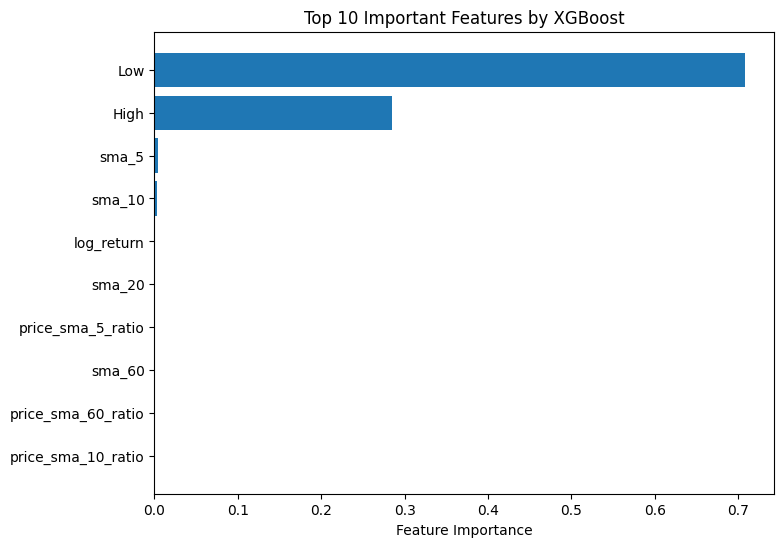

Selected features: ['Low', 'High', 'sma_5', 'sma_10', 'log_return', 'sma_20', 'price_sma_5_ratio', 'sma_60', 'price_sma_60_ratio', 'price_sma_10_ratio']


In [127]:
def feature_selection_with_xgb(df_feat, target_col='close', top_k=10):
    # define target and features
    X = df_feat.drop(columns=[target_col])
    y = df_feat[target_col]

    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, shuffle=False)

    # Use XGBoost for feature importance
    model = XGBRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)],verbose=False)

    # Get feature importance
    importance = model.feature_importances_
    features = X.columns

    # Create a DataFrame for feature importance
    imp_df = pd.DataFrame({'feature': features, 'importance': importance})
    imp_df = imp_df.sort_values(by='importance', ascending=False).head(top_k)

    plt.figure(figsize=(8, 6))
    plt.barh(imp_df['feature'], imp_df['importance'])
    plt.xlabel('Feature Importance')
    plt.title(f'Top {top_k} Important Features by XGBoost')
    plt.gca().invert_yaxis()
    plt.show()

    return imp_df['feature'].tolist()


top_features = feature_selection_with_xgb(df, target_col='Close', top_k=10)
print("Selected features:", top_features)


In [128]:
df = df[['Close'] + top_features]
df = df.dropna()
df.head()

Price,Close,Low,High,sma_5,sma_10,log_return,sma_20,price_sma_5_ratio,sma_60,price_sma_60_ratio,price_sma_10_ratio
Date,,,,,,,,,,,
2015-02-03,30.069128,29.881330,30.228031,30.106689,30.643353,0.000961,30.774813,0.998752,30.744149,0.978044,0.981261
2015-02-04,30.105249,30.061911,30.401390,30.072021,30.522009,0.001201,30.746644,1.001105,30.716370,0.980104,0.986346
2015-02-05,30.184694,29.982450,30.206362,30.027237,30.378273,0.002635,30.703306,1.005244,30.694217,0.983400,0.993628
2015-02-06,29.939116,29.845216,30.163025,30.067684,30.243925,-0.008169,30.628909,0.995724,30.664013,0.976360,0.989922
2015-02-09,29.780214,29.642979,29.939120,30.015680,30.116078,-0.005322,30.563902,0.992155,30.630021,0.972256,0.988848


In [129]:
# Choosing between Standardization or normalization
# sc=StandardScaler()
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df)
scaled_df = pd.DataFrame(data_scaled, columns=df.columns, index=df.index)


In [130]:
# Building the sample for the LSTM
X, y, dates = [], [], []
for i in range(len(scaled_df) - sequence_length - n_days):
    X.append(scaled_df.iloc[i:i+sequence_length].values)
    y.append(scaled_df.iloc[i+sequence_length:i+sequence_length+n_days]['Close'].values)
    dates.append(scaled_df.index[i+sequence_length:i+sequence_length+n_days])

X = np.array(X)
y = np.array(y)
dates = np.array(dates)

print('X shape:', X.shape)
print('y shape:', y.shape)
print('y_dates shape:', dates.shape)

# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Convert to tensors
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Loaders
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

X shape: (2530, 60, 11)
y shape: (2530, 1)
y_dates shape: (2530, 1)


In [131]:
# === [Positional Encoding Module] ===
class EarlyStopping:
    def __init__(self, patience=25, delta=1e-4):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_loss = float('inf')
        self.best_state = None
        self.early_stop = False

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.best_state = model.state_dict()
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=500):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(pos * div_term)
        pe[:, 1::2] = torch.cos(pos * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

# === [Transformer Model] ===
class TransformerTimeSeries(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim, seq_length, num_blocks, num_features, dropout):
        super().__init__()
        self.input_linear = nn.Linear(num_features, embed_dim)
        self.pos_encoding = PositionalEncoding(embed_dim, max_len=seq_length)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=ff_dim,
            dropout=dropout,
            activation="relu"
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_blocks)
        self.fc_out = nn.Sequential(
            nn.Flatten(),
            nn.Linear(embed_dim * seq_length, 1)
        )
    def forward(self, x):
        x = self.input_linear(x)
        x = self.pos_encoding(x)
        x = self.transformer_encoder(x)
        return self.fc_out(x)

In [132]:
from sklearn.model_selection import train_test_split

# === [Split training set into actual train and validation sets] ===
X_train_actual, X_val, y_train_actual, y_val = train_test_split(
    X_train, y_train, test_size=0.2, shuffle=False
)

# Convert to tensors
X_train_tensor = torch.tensor(X_train_actual, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_actual, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

# Dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Model, criterion, optimizer (same as before)
num_features = X_train_tensor.shape[2]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TransformerTimeSeries(embed_dim, num_heads, ff_dim, sequence_length, num_blocks, num_features, dropout).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Early stopping
early_stopping = EarlyStopping(patience=25)

# Training loop with validation
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        pred = model(batch_X)
        loss = criterion(pred.squeeze(), batch_y.squeeze())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_train_loss = total_loss / len(train_loader)

    # Validation loss
    model.eval()
    with torch.no_grad():
        val_pred = model(X_val_tensor.to(device))
        val_loss = criterion(val_pred.squeeze(), y_val_tensor.to(device).squeeze()).item()

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.6f}, Val Loss: {val_loss:.6f}")

    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping triggered.")
        break

# Restore best model weights
model.load_state_dict(early_stopping.best_state)


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/100, Train Loss: 0.223541, Val Loss: 0.003205
Epoch 2/100, Train Loss: 0.015025, Val Loss: 0.002715
Epoch 3/100, Train Loss: 0.012867, Val Loss: 0.008193
Epoch 4/100, Train Loss: 0.010329, Val Loss: 0.002198
Epoch 5/100, Train Loss: 0.009290, Val Loss: 0.009779
Epoch 6/100, Train Loss: 0.008463, Val Loss: 0.001360
Epoch 7/100, Train Loss: 0.008895, Val Loss: 0.010983
Epoch 8/100, Train Loss: 0.008225, Val Loss: 0.008988
Epoch 9/100, Train Loss: 0.006798, Val Loss: 0.001771
Epoch 10/100, Train Loss: 0.006706, Val Loss: 0.004513
Epoch 11/100, Train Loss: 0.005309, Val Loss: 0.002890
Epoch 12/100, Train Loss: 0.005156, Val Loss: 0.005018
Epoch 13/100, Train Loss: 0.004472, Val Loss: 0.001590
Epoch 14/100, Train Loss: 0.003644, Val Loss: 0.002107
Epoch 15/100, Train Loss: 0.004597, Val Loss: 0.000915
Epoch 16/100, Train Loss: 0.006727, Val Loss: 0.001087
Epoch 17/100, Train Loss: 0.005090, Val Loss: 0.017718
Epoch 18/100, Train Loss: 0.004941, Val Loss: 0.005304
Epoch 19/100, Train

<All keys matched successfully>

In [133]:
# === [Evaluate on Test Set and Inverse Transform] ===
model.eval()
with torch.no_grad():
    test_preds = model(X_test_tensor.to(device)).cpu().numpy().flatten()
    test_actual = y_test_tensor.numpy().flatten()

# Inverse transform predictions and actual values
close_idx = df.columns.get_loc('Close')

y_test_full, y_pred_full = [], []
for i in range(len(y_test)):
    temp = np.zeros((n_days, data_scaled.shape[1]))
    temp[:, close_idx] = y_test[i]
    y_test_full.append(scaler.inverse_transform(temp)[:, close_idx])

    temp[:, close_idx] = test_preds[i]
    y_pred_full.append(scaler.inverse_transform(temp)[:, close_idx])

y_test_flat = np.array(y_test_full).flatten()
y_pred_flat = np.array(y_pred_full).flatten()

rmse = np.sqrt(mean_squared_error(y_test_flat, y_pred_flat))
mae = mean_absolute_error(y_test_flat, y_pred_flat)
print(f'RMSE: {rmse:.2f}')
print(f'MAE: {mae:.2f}')

RMSE: 2.39
MAE: 1.74


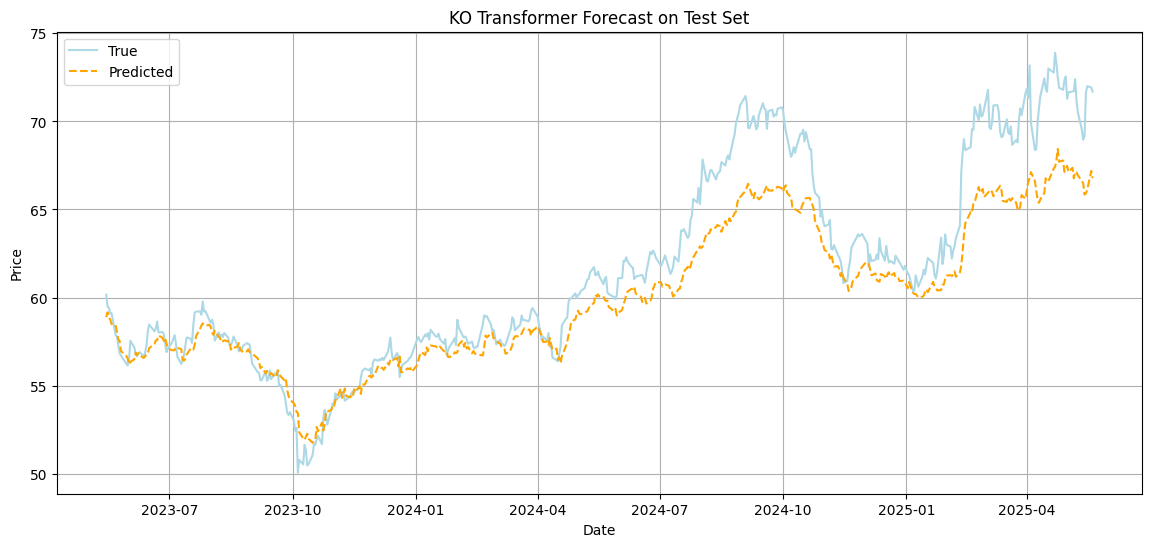

In [134]:
# === [Plot Predicted vs Actual on Test Set] ===
plt.figure(figsize=(14, 6))
plt.plot(dates_test.flatten(), np.array(y_test_flat), label='True', color='lightblue')
plt.plot(dates_test.flatten(), np.array(y_pred_flat), label='Predicted', linestyle='--', color='orange')
plt.title(f'{ticker} Transformer Forecast on Test Set')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

In [135]:
future_predictions = []
prediction_length = n_days
input_seq = data_scaled[-sequence_length:].reshape((1, sequence_length, data_scaled.shape[1]))

In [136]:
pred = model(torch.tensor(input_seq, dtype=torch.float32))  # shape: (1, n_steps_out, 1)
pred_close_scaled = pred[0, :]  # shape: (n_steps_out,)
future_predictions = pred_close_scaled.tolist()

In [137]:
temp = np.zeros((n_days, data_scaled.shape[1]))
temp[:, close_idx] = future_predictions
future_pred_prices = scaler.inverse_transform(temp)[:, close_idx]

In [138]:
print(f"Future predictions for the next {n_days} days: {future_pred_prices}")

Future predictions for the next 1 days: [66.46478828]


In [139]:
data_predict = yf.download(ticker, start='2025-05-02', end='2025-05-03')

# Actual Close prices for the next day
print(data_predict['Close'])

[*********************100%***********************]  1 of 1 completed

Ticker             KO
Date                 
2025-05-02  71.650002
